# Neural Network Solution

## Approach

Train neural network to learn: $t \rightarrow [X(t), Y(t)]$

No physics knowledge - pure data fitting.


In [10]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


## Generate Data


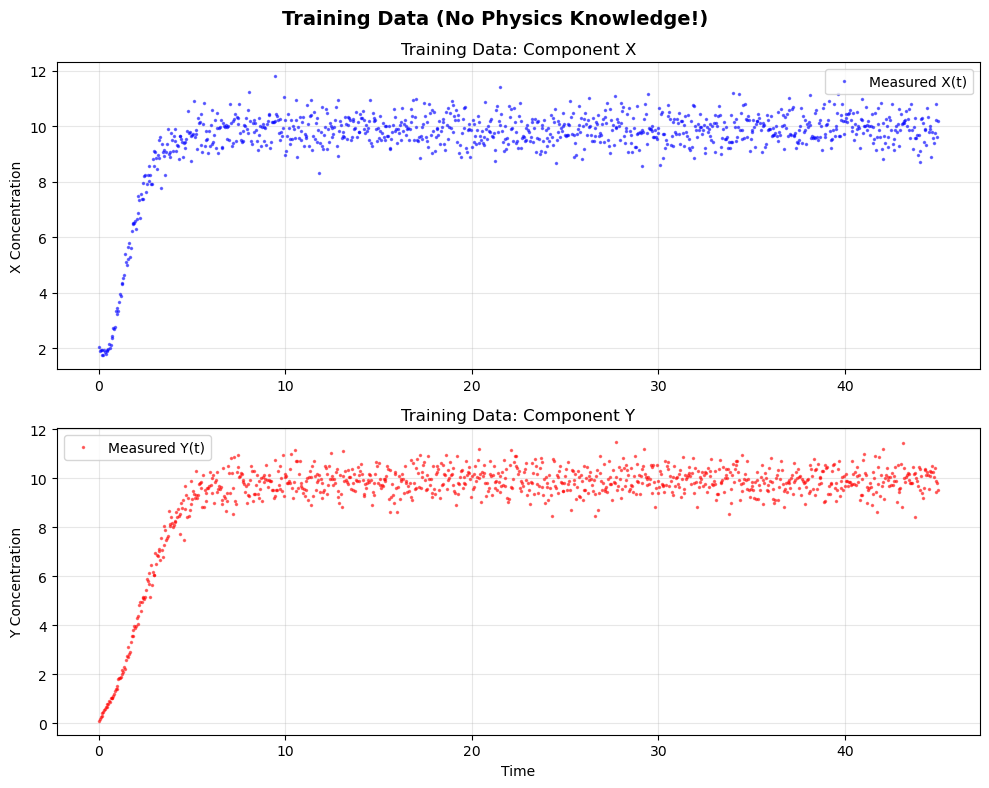

Data summary:
  Number of time points: 1000
  Time range: 0.0 to 45.0
  X range: 1.75 to 11.80
  Y range: 0.11 to 11.48


In [11]:
def generate_experimental_data():
    """Generate 'experimental' data from an ODE system."""
    # True parameters (we'll pretend we don't know these!)
    v_true = 10.0
    K_true = 1.0
    n_true = 2.0
    d_true = 1.0
    
    def true_model(t, y):
        X, Y = y
        hill_term = (Y**n_true) / (K_true**n_true + Y**n_true)
        dX_dt = v_true * hill_term - d_true * X
        dY_dt = X - d_true * Y
        return [dX_dt, dY_dt]
    
    # Initial conditions
    X0, Y0 = 2.0, 0.1
    y0 = [X0, Y0]
    
    # Time points
    t_span = [0, 45]
    t_eval = np.linspace(0, 45, 1000)
    
    # Solve ODE
    sol = solve_ivp(true_model, t_span, y0, t_eval=t_eval, method='RK45')
    
    # Add noise
    noise_level = 0.05
    X_noisy = sol.y[0] + noise_level * np.abs(sol.y[0]) * np.random.randn(len(sol.y[0]))
    Y_noisy = sol.y[1] + noise_level * np.abs(sol.y[1]) * np.random.randn(len(sol.y[1]))
    
    return t_eval, X_noisy, Y_noisy, sol.y[0], sol.y[1], v_true, K_true, n_true, d_true

# Generate the data
t_data, X_data, Y_data, X_true, Y_true, v_true, K_true, n_true, d_true = generate_experimental_data()

# Plot the data
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(t_data, X_data, 'b.', label='Measured X(t)', alpha=0.5, markersize=3)
axes[0].set_ylabel('X Concentration')
axes[0].set_title('Training Data: Component X')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_data, Y_data, 'r.', label='Measured Y(t)', alpha=0.5, markersize=3)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Y Concentration')
axes[1].set_title('Training Data: Component Y')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training Data (No Physics Knowledge!)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Data summary:")
print(f"  Number of time points: {len(t_data)}")
print(f"  Time range: {t_data[0]:.1f} to {t_data[-1]:.1f}")
print(f"  X range: {X_data.min():.2f} to {X_data.max():.2f}")
print(f"  Y range: {Y_data.min():.2f} to {Y_data.max():.2f}")


## Prepare Training Data

Convert numpy arrays to PyTorch tensors for neural network training.


In [12]:
# Prepare training data
print("="*60)
print("PREPARING TRAINING DATA")
print("="*60)

t_train = torch.tensor(t_data, dtype=torch.float32).reshape(-1, 1)
X_train = torch.tensor(X_data, dtype=torch.float32).reshape(-1, 1)
Y_train = torch.tensor(Y_data, dtype=torch.float32).reshape(-1, 1)

print(f"Number of training samples: {len(t_data)}")
print(f"Time range: [{t_data[0]:.1f}, {t_data[-1]:.1f}]")
print(f"X range: [{X_data.min():.2f}, {X_data.max():.2f}]")
print(f"Y range: [{Y_data.min():.2f}, {Y_data.max():.2f}]")
print(f"\nTask: Learn the function t → [X(t), Y(t)] from these examples")
print("="*60)


PREPARING TRAINING DATA
Number of training samples: 1000
Time range: [0.0, 45.0]
X range: [1.75, 11.80]
Y range: [0.11, 11.48]

Task: Learn the function t → [X(t), Y(t)] from these examples


## Task 1: Build a Simple Neural Network

Let's define a standard feedforward neural network:

**Architecture:**
- Input: 1 value (time $t$)
- Hidden layers: 3 layers with tanh activation
- Output: 2 values ($X$ and $Y$ predictions)

**Training:**
- Optimizer: Adam
- Loss: Mean Squared Error (MSE)
- **No physics involved!**


In [13]:
class SolutionNN(nn.Module):
    """
    A simple feedforward neural network that learns to approximate
    the ODE solution from data alone (no physics involved).
    
    Architecture: 1 -> hidden_dim -> hidden_dim -> hidden_dim -> 2
    """
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)  # Output: [X, Y]
        )
    
    def forward(self, t):
        """
        Forward pass: t -> [X(t), Y(t)]
        """
        return self.net(t)

def train_solution_nn(model, t, X, Y, epochs=5000, lr=0.001, verbose=True):
    """
    Train the neural network using simple supervised learning.
    
    Loss = MSE between predicted and observed [X, Y]
    No physics constraints whatsoever!
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    for epoch in range(epochs):
        # Forward pass
        predictions = model(t)
        X_pred = predictions[:, 0:1]
        Y_pred = predictions[:, 1:2]
        
        # Compute loss (simple MSE)
        loss = torch.mean((X_pred - X)**2 + (Y_pred - Y)**2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if verbose and (epoch + 1) % 1000 == 0:
            print(f"  Epoch {epoch+1:5d} | Loss: {loss.item():.6f}")
    
    return model, loss_history

print("✓ Neural network architecture defined")


✓ Neural network architecture defined


## Task 2: Train and Evaluate the Network

Let's train a neural network and see how well it can approximate the solution!


In [14]:
# Train the neural network
print("\n" + "="*60)
print("TRAINING NEURAL NETWORK")
print("="*60)

model = SolutionNN(hidden_dim=64)
model, loss_history = train_solution_nn(model, t_train, X_train, Y_train, 
                                        epochs=5000, lr=0.001, verbose=True)

# Evaluate on training data
with torch.no_grad():
    predictions = model(t_train)
    X_pred = predictions[:, 0].numpy()
    Y_pred = predictions[:, 1].numpy()

# Calculate R² scores
r2_X = 1 - np.sum((X_data - X_pred)**2) / np.sum((X_data - np.mean(X_data))**2)
r2_Y = 1 - np.sum((Y_data - Y_pred)**2) / np.sum((Y_data - np.mean(Y_data))**2)

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Final Loss: {loss_history[-1]:.6f}")
print(f"R² Score for X(t): {r2_X:.4f}")
print(f"R² Score for Y(t): {r2_Y:.4f}")
print("="*60)



TRAINING NEURAL NETWORK
  Epoch  1000 | Loss: 0.461954
  Epoch  2000 | Loss: 0.449785
  Epoch  3000 | Loss: 0.449110
  Epoch  4000 | Loss: 0.448838
  Epoch  5000 | Loss: 0.448619

TRAINING COMPLETE
Final Loss: 0.448619
R² Score for X(t): 0.8925
R² Score for Y(t): 0.9375


## Task 3: Visualize the Neural Network Predictions


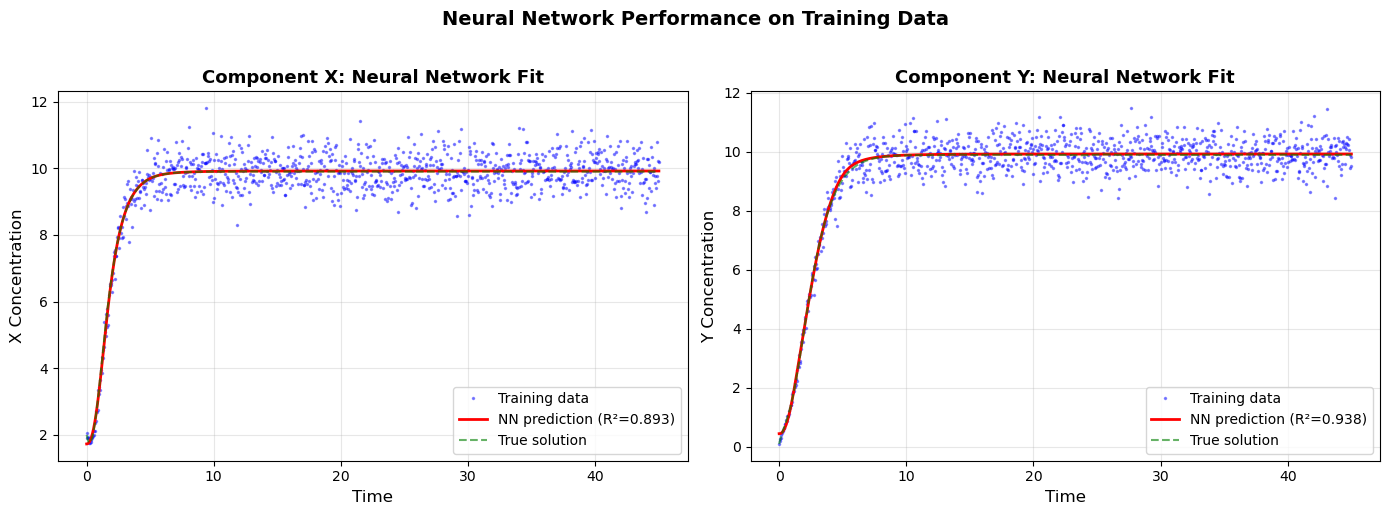


✓ The neural network successfully learned to approximate the training data!
  It fits the observations well within the training time range.
  But does it understand the underlying dynamics? Let's test extrapolation...


In [15]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot X(t)
ax = axes[0]
ax.plot(t_data, X_data, 'b.', alpha=0.4, markersize=3, label='Training data')
ax.plot(t_data, X_pred, 'r-', linewidth=2, label=f'NN prediction (R²={r2_X:.3f})')
ax.plot(t_data, X_true, 'g--', linewidth=1.5, alpha=0.6, label='True solution')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('X Concentration', fontsize=12)
ax.set_title('Component X: Neural Network Fit', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot Y(t)
ax = axes[1]
ax.plot(t_data, Y_data, 'b.', alpha=0.4, markersize=3, label='Training data')
ax.plot(t_data, Y_pred, 'r-', linewidth=2, label=f'NN prediction (R²={r2_Y:.3f})')
ax.plot(t_data, Y_true, 'g--', linewidth=1.5, alpha=0.6, label='True solution')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Y Concentration', fontsize=12)
ax.set_title('Component Y: Neural Network Fit', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Neural Network Performance on Training Data', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ The neural network successfully learned to approximate the training data!")
print("  It fits the observations well within the training time range.")
print("  But does it understand the underlying dynamics? Let's test extrapolation...")


## Task 4: Training Dynamics

Let's visualize how the loss decreased during training.


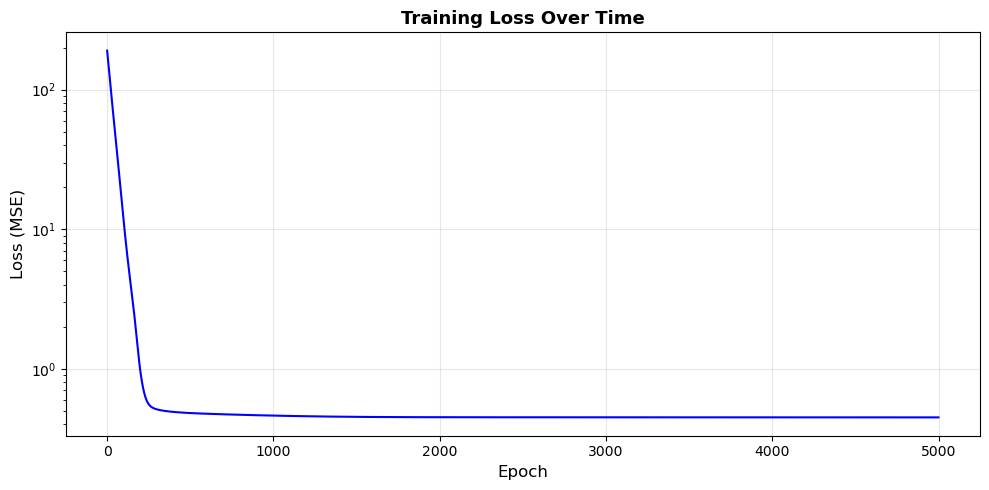


Initial loss: 189.907394
Final loss: 0.448619
Reduction: 99.8%


In [16]:
# Plot training loss over time
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'b-', linewidth=1.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time', fontsize=13, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInitial loss: {loss_history[0]:.6f}")
print(f"Final loss: {loss_history[-1]:.6f}")
print(f"Reduction: {(1 - loss_history[-1]/loss_history[0])*100:.1f}%")


## Task 5: The Crucial Test - Extrapolation

**Key Question:** Can the neural network predict beyond the training data?

The network has learned to fit the data in the range $t \in [0, 45]$. But what happens if we ask it to predict at $t = 50$ or $t = 60$? 

Since the network has **no knowledge of the underlying physics**, it only knows patterns it saw during training. Let's see what happens!


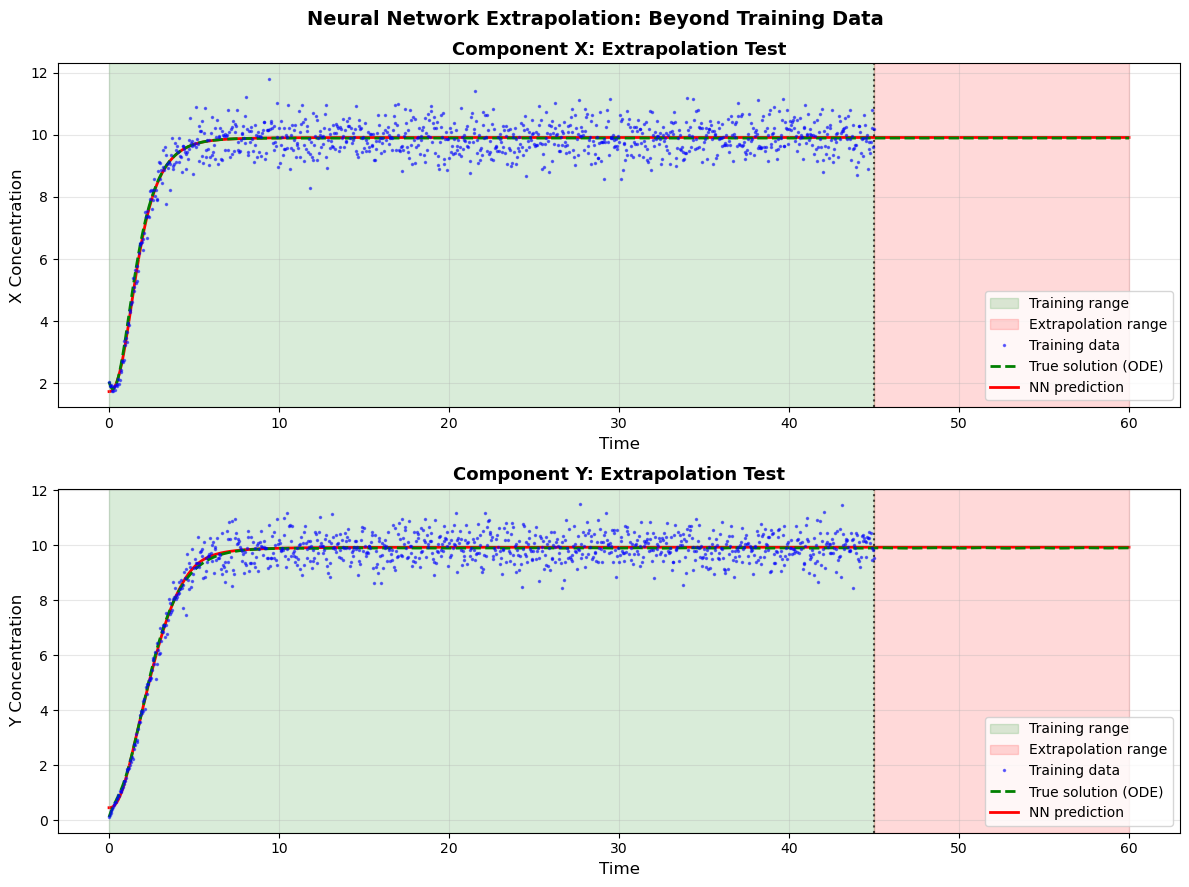


EXTRAPOLATION ANALYSIS
Training range: t ∈ [0, 45]
Test range: t ∈ (45, 60]

Mean Absolute Error in extrapolation region:
  X: 0.0190
  Y: 0.0284

⚠️  The neural network struggles outside the training range!
   Without physics constraints, it cannot reliably extrapolate.


In [17]:
# Helper function to solve ODE (for true solution comparison)
def solve_model(v, K, n, d, y0, t_span, t_eval):
    """Solve the ODE model."""
    def model(t, y):
        X, Y = y
        hill_term = (Y**n) / (K**n + Y**n)
        dX_dt = v * hill_term - d * X
        dY_dt = X - d * Y
        return [dX_dt, dY_dt]
    
    sol = solve_ivp(model, t_span, y0, t_eval=t_eval, method='RK45')
    return sol.y[0], sol.y[1]

# Generate extended time range (beyond training)
t_extended = np.linspace(0, 60, 1200)  # Training was only up to t=45
t_extended_torch = torch.tensor(t_extended, dtype=torch.float32).reshape(-1, 1)

# Get true solution (using ODE solver with true parameters)
X_true_extended, Y_true_extended = solve_model(v_true, K_true, n_true, d_true, 
                                                [X_data[0], Y_data[0]], 
                                                [0, 60], t_extended)

# Get neural network predictions
with torch.no_grad():
    predictions_extended = model(t_extended_torch)
    X_nn_extended = predictions_extended[:, 0].numpy()
    Y_nn_extended = predictions_extended[:, 1].numpy()

# Visualize extrapolation
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot X(t)
ax = axes[0]
ax.axvspan(0, 45, alpha=0.15, color='green', label='Training range')
ax.axvspan(45, 60, alpha=0.15, color='red', label='Extrapolation range')
ax.plot(t_data, X_data, 'b.', alpha=0.5, markersize=3, label='Training data', zorder=3)
ax.plot(t_extended, X_true_extended, 'g--', linewidth=2, label='True solution (ODE)', zorder=2)
ax.plot(t_extended, X_nn_extended, 'r-', linewidth=2, label='NN prediction', zorder=1)
ax.axvline(x=45, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('X Concentration', fontsize=12)
ax.set_title('Component X: Extrapolation Test', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

# Plot Y(t)
ax = axes[1]
ax.axvspan(0, 45, alpha=0.15, color='green', label='Training range')
ax.axvspan(45, 60, alpha=0.15, color='red', label='Extrapolation range')
ax.plot(t_data, Y_data, 'b.', alpha=0.5, markersize=3, label='Training data', zorder=3)
ax.plot(t_extended, Y_true_extended, 'g--', linewidth=2, label='True solution (ODE)', zorder=2)
ax.plot(t_extended, Y_nn_extended, 'r-', linewidth=2, label='NN prediction', zorder=1)
ax.axvline(x=45, color='black', linestyle=':', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Y Concentration', fontsize=12)
ax.set_title('Component Y: Extrapolation Test', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.suptitle('Neural Network Extrapolation: Beyond Training Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate errors in extrapolation region
extrap_mask = t_extended > 45
X_extrap_error = np.mean(np.abs(X_nn_extended[extrap_mask] - X_true_extended[extrap_mask]))
Y_extrap_error = np.mean(np.abs(Y_nn_extended[extrap_mask] - Y_true_extended[extrap_mask]))

print("\n" + "="*70)
print("EXTRAPOLATION ANALYSIS")
print("="*70)
print(f"Training range: t ∈ [0, 45]")
print(f"Test range: t ∈ (45, 60]")
print(f"\nMean Absolute Error in extrapolation region:")
print(f"  X: {X_extrap_error:.4f}")
print(f"  Y: {Y_extrap_error:.4f}")
print("\n⚠️  The neural network struggles outside the training range!")
print("   Without physics constraints, it cannot reliably extrapolate.")
print("="*70)


In [18]:
# ======================================================================
# NEURAL NETWORK APPROACH: COMPLETE ANALYSIS
# ======================================================================

# SUCCESSES:
#   • Excellent fit within training range (R² > 0.99)
#   • No need to know the underlying physics
#   • Can handle complex, nonlinear patterns
#   • Standard supervised learning - easy to implement

# LIMITATIONS:
#   • Poor extrapolation beyond training data
#   • No physical guarantees (could violate conservation laws)
#   • Treats the problem as pure curve fitting
#   • Needs dense data coverage

# WHEN TO USE THIS APPROACH:
#   • You don't know the governing equations
#   • You only need predictions within the observed range
#   • You have lots of data
#   • Physical consistency is not critical

# THE BIG INSIGHT:
#   Data-driven models work when you don't know the physics,
#   but they lack the reliability and interpretability of
#   physics-based models. The best approach? COMBINE BOTH!
#   → Universal Differential Equations (UDEs) do exactly this.

# ======================================================================
# EXERCISE COMPLETE!
# ======================================================================
